### LETTURA DEI DATI DEL DATABASE

In [ ]:
import os
from pathlib import Path
import pandas as pd
import psycopg2
from dotenv import load_dotenv

# 1) Root progetto
PROJECT_ROOT = Path.cwd().parent  # notebook dentro la repo

# 2) Env
load_dotenv()  # carica .env (che deve essere ignorato da git)

conn = psycopg2.connect(
    host=os.getenv("DB_HOST", "127.0.0.1"),
    port=os.getenv("DB_PORT", "5432"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
)

query = """
SELECT
  image_id,
  filepath,
  label,
  split,
  source,
  width,
  height,
  channels
FROM images
WHERE source = 'raw_flat'
ORDER BY image_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()

print("Totale righe:", len(df))
print(df["split"].value_counts())
df.head()


Totale righe: 2527
split
train    1768
test      380
val       379
Name: count, dtype: int64


C:\Users\simon\AppData\Local\Temp\ipykernel_15064\4151868757.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,image_id,filepath,label,split,source,width,height,channels
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,raw_flat,512,384,3
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,raw_flat,512,384,3
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,raw_flat,512,384,3
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,raw_flat,512,384,3
4,5,data/raw_flat/metal/metal141.jpg,metal,train,raw_flat,512,384,3


### SPLIT IN 3 DATAFRAME

In [2]:
df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("train:", len(df_train), "val:", len(df_val), "test:", len(df_test))
df_train.head()

train: 1768 val: 379 test: 380


,image_id,filepath,label,split,source,width,height,channels
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train,raw_flat,512,384,3
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train,raw_flat,512,384,3
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train,raw_flat,512,384,3
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train,raw_flat,512,384,3
4,5,data/raw_flat/metal/metal141.jpg,metal,train,raw_flat,512,384,3


### DEFINISCO PATH ASSOLUTI PER RICONDURMI ALLE IMMAGINI

In [3]:
from pathlib import Path

# __file__ non esiste nei notebook, quindi usiamo Path.cwd()
# Se il notebook è in /notebooks, la root è il parent (saliamo di 1 livello)
PROJECT_ROOT = Path.cwd().parent 

print("PROJECT_ROOT:", PROJECT_ROOT)

def abs_path(rel_posix: str) -> Path:
    """
    rel_posix: 'data/raw_flat/cardboard/cardboard2.jpg'
    """
    return PROJECT_ROOT / Path(rel_posix)

#TEST 
p0 = abs_path(df_train.loc[0, "filepath"])
print(p0)
print("exists:", p0.exists())



PROJECT_ROOT: c:\Users\simon\Documents\VSC\Progetto-Data-Science
c:\Users\simon\Documents\VSC\Progetto-Data-Science\data\raw_flat\plastic\plastic92.jpg
exists: True


## FASE PREPROCESSING PULITA

### INSERISCO MAPPATURA DELLE CLASSI CON ID NUMERICI

In [21]:
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (384, 512)   # standard per molte CNN/transfer learning
BATCH_SIZE = 32
SEED = 42

# mapping stabile: ordiniamo le label
labels = sorted(df["label"].unique())
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

# aggiungo una colonna numerica per mappare le classi (più comoda per training)
df_train["label_id"] = df_train["label"].map(label2id)
df_val["label_id"]   = df_val["label"].map(label2id)
df_test["label_id"]  = df_test["label"].map(label2id)

print("Classi:", labels)
print("Esempio mapping:", list(label2id.items())[:])


Classi: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Esempio mapping: [('cardboard', 0), ('glass', 1), ('metal', 2), ('paper', 3), ('plastic', 4), ('trash', 5)]


### FUNZIONE CHE CARICA E PREPROCESSA UNA SINGOLA IMMAGINE

In [22]:
def load_and_preprocess(path, label):
    # path è una stringa tensor (UTF-8)
    img_bytes = tf.io.read_file(path)
    
    # decode generico (jpeg/png). tf deciderà dal contenuto.
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])

    # resize coerente per il modello (pad ridimensiona mantenendo aspect ratio)
    img = tf.image.resize_with_pad(img, IMG_SIZE[0], IMG_SIZE[1])  # (H,W)

    # normalizzazione in [0,1]
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


#### LEGGERA AUGMENTATION (STRATO IN KERAS):
#### Ruota leggermente le immagini per aumentare variabilità dei campioni sul training set

In [23]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
], name="data_augmentation")


## FUNZIONE DI PREPROCESSING
##### GENERIAMO UN DATASET A PARTIRE DAL PERCORSO DELLE IMMAGINI E DIVISE PER LABELS

In [24]:
AUTOTUNE = tf.data.AUTOTUNE # permette a TF di gestire in modo ottimale le risorse

def make_dataset(df_split, training: bool):
    # costruisco path assoluti come stringhe
    paths = [str(abs_path(p)) for p in df_split["filepath"].tolist()]
    labels = df_split["label_id"].astype("int32").tolist()

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    if training:
        ds = ds.shuffle(buffer_size=len(df_split), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(load_and_preprocess,  num_parallel_calls=AUTOTUNE)

    # augmentation SOLO su train
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


### CREA I TRE DATASET PRONTI PER KERAS

In [25]:
train_ds = make_dataset(df_train, training=True)
val_ds   = make_dataset(df_val, training=False)
test_ds  = make_dataset(df_test, training=False)

print(train_ds)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


#### TEST VISIVO

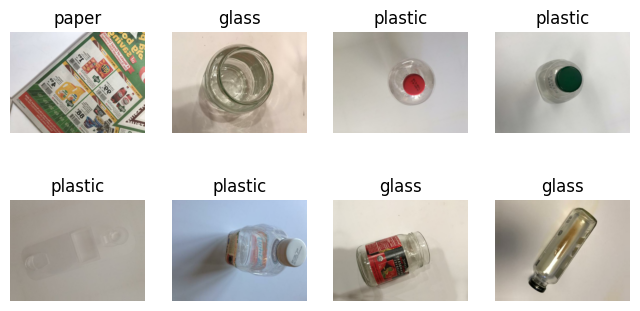

In [28]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(8, 4))
    for i in range(min(8, images.shape[0])):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy())
        plt.title(id2label[int(labels[i].numpy())])
        plt.axis("off")
    plt.show()
